In [1]:
import os
import math

import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

from scipy.spatial.distance import pdist, squareform
from scipy import linalg

In [2]:
# Define paths to your CSV files
path_iris_33 = "iris_33.csv"

# Read the CSV files into pandas DataFrames
iris_33 = pd.read_csv(path_iris_33)
labels = iris_33["target"] 
data_df = iris_33.drop(columns=["target"])  # Replace "target" with your actual target column name

In [3]:
# Drop the target column from features DataFrame
data_df = iris_33.drop(["Index","target"], axis=1)
data_df

,sepal_length,sepal_width,petal_length,petal_width
0,0.000,0.417,0.017,0.000
1,0.222,0.583,0.085,0.042
2,0.139,0.458,0.102,0.042
3,0.139,0.417,0.068,0.083
4,0.222,0.625,0.068,0.083
5,0.278,0.708,0.085,0.042
6,0.194,0.583,0.102,0.125
7,0.194,0.417,0.102,0.042
8,0.250,0.875,0.085,0.000
9,0.222,0.750,0.085,0.083


In [4]:
def spectral_clustering(dataframe, labels, similarity_graph, laplacian, number_of_clusters, local_sigma = None, epsilon = None, k_knn = None, k_mknn = None):

    # Pairwise distances
    dimension = dataframe.shape[0]
    dist_mat = squareform(pdist(dataframe))

    if similarity_graph == "full":

        #calculate local sigma
        sigmas = np.zeros(dimension)
        for i in tqdm(range(len(dist_mat))):
            sigmas[i] = sorted(dist_mat[i])[local_sigma]

        # Adjaceny matrix with optimal sigma
        adjacency_matrix = np.zeros([dimension, dimension])
        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):
                d = np.exp(-1*dist_mat[i,j]**2/(sigmas[i]*sigmas[j]))
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d


    elif similarity_graph == "eps":

        # Adjaceny matrix with epsilon threshold
        adjacency_matrix = np.zeros([dimension, dimension])

        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):
                if dist_mat[i,j] < epsilon:
                    d = 1
                else:
                    d = 0
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d


    elif similarity_graph == "knn":

        # Adjaceny matrix with k-neighbours
        adjacency_matrix = np.zeros([dimension, dimension])

        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k_knn+1]  # Exclude the node itself

            # Update the adjacency matrix
            adjacency_matrix[i, k_nearest_indices] = 1


    else:

        # Adjaceny matrix with mutual k-neighbours
        adjacency_matrix = np.zeros([dimension, dimension])

        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k_mknn+1]  # Exclude the node itself

            for neighbor in k_nearest_indices:
                # Check if node i is also among the k-nearest neighbors of the current neighbor
                neighbor_sorted_indices = np.argsort(dist_mat[neighbor])
                if i in neighbor_sorted_indices[1:k_mknn+1]:
                    # Connect nodes if they are mutual k-nearest neighbors
                    adjacency_matrix[i, neighbor] = 1
                    adjacency_matrix[neighbor, i] = 1

    # Calculate degree matrix
    degrees = np.sum(adjacency_matrix, axis=1)
    degree_matrix = np.diag(degrees)

    if laplacian == "sym":

        # Normalized Symmetric laplacian matrix
        d_inv_sqrt = np.zeros_like(degrees)
        nonzero = degrees > 0
        d_inv_sqrt[nonzero] = 1.0 / np.sqrt(degrees[nonzero])
        d_half = np.diag(d_inv_sqrt)
        laplacian_matrix_normalized = d_half @ adjacency_matrix @ d_half

    if laplacian == "rw":

        # Normalized Random Walk laplacian matrix
        d_inv = np.zeros_like(degrees)
        nonzero = degrees > 0
        d_inv[nonzero] = 1.0 / degrees[nonzero]
        d_inverse = np.diag(d_inv)
        laplacian_matrix_normalized = d_inverse @ adjacency_matrix

    if laplacian == "ad":

        # Adaptive Laplacian matrix
        D_local = np.zeros_like(degrees)
        for i in range(len(degrees)):
            neighbors = np.where(adjacency_matrix[i] > 0)[0]
            if len(neighbors) > 0 and degrees[i] > 0:
                D_local[i] = np.sum(degrees[neighbors]) / degrees[i]
            else:
                D_local[i] = 0
        D_local_inv_sqrt = np.zeros_like(D_local)
        nonzero = D_local > 0
        D_local_inv_sqrt[nonzero] = 1.0 / np.sqrt(D_local[nonzero])
        D_local_inv = np.diag(D_local_inv_sqrt)
        laplacian_matrix_normalized = D_local_inv @ adjacency_matrix @ D_local_inv

    if check_symmetric(laplacian_matrix_normalized) :
        # Calculating eigenvalues and eigenvectors for symmetric matrix
        e, v = np.linalg.eigh(laplacian_matrix_normalized)
    else:
        # Calculating eigenvalues and eigenvectors for non-symmetric matrix
        e, v = np.linalg.eig(laplacian_matrix_normalized)
        idx = np.argsort(np.real(e))
        e = np.real(e[idx])
        v = np.real(v[:, idx])

    # Calculate eigengap
    eigengap = np.diff(e)
    optimal_number_of_clusters = np.argmax(eigengap[:10]) + 1

    if number_of_clusters != None:
        # First case: k
        n_clusters = max(number_of_clusters,2)
    else:
        # Second case: optimal number of clusters from eigengap
        n_clusters = max(optimal_number_of_clusters,2)

    results = []
    
    # KMeans clustering
    X = v[:, -n_clusters:]
    clustering = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)
    cluster_labels = clustering.fit_predict(X)

    adj_filename, laplacian_filename, X_filename, dist_filename, eigenval, eigenvec = save_matrices(similarity_graph,laplacian, adjacency_matrix, laplacian_matrix_normalized, X, dist_mat,e,v)

    # Calculate evaluation metrics
    sil_score = silhouette_score(dataframe, cluster_labels)
    ar_score = adjusted_rand_score(labels, cluster_labels)

    # results.append((sil_score, ar_score, n_clusters,cluster_labels))
    results.append((sil_score, ar_score, n_clusters,cluster_labels, adj_filename, laplacian_filename, X_filename, dist_filename, eigenval, eigenvec))

    return results

In [5]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [6]:
def save_matrices(sim_graph, laplace, adjacency_matrix, laplacian_matrix, X_matrix, dist_matrix, eigenvalues, eigenvectors):
    # Unique filenames for matrices based on parameters
    adj_filename = f"debug/adjacency_{sim_graph}_{laplace}.csv"
    laplacian_filename = f"debug/laplacian_{sim_graph}_{laplace}.csv"
    X_filename = f"debug/X_{sim_graph}_{laplace}.csv"
    dist_filename = f"debug/dist_{sim_graph}_{laplace}.csv"
    eigenvalues_filename = f"debug/eigenvalues_{sim_graph}_{laplace}.csv"
    eigenvectors_filename = f"debug/eigenvectors_{sim_graph}_{laplace}.csv"
    
    # Save matrices
    pd.DataFrame(adjacency_matrix).to_csv(adj_filename, index=False)
    pd.DataFrame(laplacian_matrix).to_csv(laplacian_filename, index=False)
    pd.DataFrame(X_matrix).to_csv(X_filename, index=False)
    pd.DataFrame(dist_matrix).to_csv(dist_filename, index=False)
    pd.DataFrame(eigenvalues).to_csv(eigenvalues_filename, index=False, header=False)
    pd.DataFrame(eigenvectors).to_csv(eigenvectors_filename, index=False)
    
    return adj_filename, laplacian_filename, X_filename, dist_filename, eigenvalues_filename, eigenvectors_filename

In [7]:
# Load saved matrices dynamically
def load_matrices(similarity_graphs, laplacian_methods, directory="./"):
    saved_matrices = {}
    for graph in similarity_graphs:
        for laplace in laplacian_methods:
            adj_file = os.path.join(directory, f"debug/adjacency_{graph}_{laplace}.csv")
            lap_file = os.path.join(directory, f"debug/laplacian_{graph}_{laplace}.csv")
            X_file = os.path.join(directory, f"debug/X_{graph}_{laplace}.csv")
            matrices = {}
            if os.path.exists(adj_file):
                matrices["adjacency"] = pd.read_csv(adj_file).to_numpy()
            if os.path.exists(lap_file):
                matrices["laplacian"] = pd.read_csv(lap_file).to_numpy()
            if os.path.exists(X_file):
                matrices["X"] = pd.read_csv(X_file).to_numpy()
            saved_matrices[f"{graph}_{laplace}"] = matrices
    return saved_matrices

In [8]:
# # Function to calculate dynamic ranges based on data size and pairwise distances
# def get_dynamic_search_space(data):
#     # Number of points in the dataset
#     n = data.shape[0]

#     # Compute pairwise distances
#     dist_mat = squareform(pdist(data))
#     flat_distances = dist_mat[np.tril_indices(n, -1)]

#     # Dynamic range for local_sigma (based on square root of n)
#     local_sigma_min = max(1, int(np.sqrt(n) / 2))
#     local_sigma_max = int(np.sqrt(n))
    
#     # Dynamic range for epsilon (based on distance percentiles)
#     epsilon_min = np.percentile(flat_distances, 80)  # 80th percentile
#     epsilon_max = np.percentile(flat_distances, 95)  # 95th percentile
    
#     # Dynamic range for k (based on number of data points)
#     k_min = max(5, int(0.01 * n))  # 1% of dataset size, but at least 5
#     k_max = min(int(0.2 * n), n - 1)  # 20% of dataset size, but never more than n-1
    
#     # Ensure k_min does not exceed k_max
#     if k_min > k_max:
#         k_min = max(5, int(0.01 * n))  # Keep dynamic range based on percentage but within limits
    
#     return (local_sigma_min, local_sigma_max), (epsilon_min, epsilon_max), (k_min, k_max)

# # Optimization functions for each parameter

# # Optimize local_sigma for "full" graph
# def optimize_local_sigma(data, labels, laplacians, number_of_clusters):
#     (local_sigma_min, local_sigma_max), _, _ = get_dynamic_search_space(data)

#     def objective_local_sigma(local_sigma):
#         silhouette_scores = []
#         local_sigma = int(local_sigma[0])
#         try:
#             for laplacian in laplacians:
#                 results = spectral_clustering(data, labels, similarity_graph="full", laplacian=laplacian, number_of_clusters=number_of_clusters, local_sigma=local_sigma)
#                 silhouette_scores.append(results[0][0])
#             return -np.mean(silhouette_scores)
#         except (ValueError, np.linalg.LinAlgError) as e:
#             print(f"Skipping local_sigma={local_sigma} due to error: {e}")
#             return 1e6  # Return a large value to penalize the failed set of hyperparameters

#     result = gp_minimize(objective_local_sigma, [(local_sigma_min, local_sigma_max)], n_calls=20, n_random_starts=10, random_state=42)

#     if result.fun < 1e6:
#         best_local_sigma = result.x[0]
#         print(f"Best local sigma: {best_local_sigma}")
#         return result
#     else:
#         print("No valid local_sigma found.")
#         return None


# # Optimize epsilon for "eps" graph
# def optimize_epsilon(data, labels, laplacians, number_of_clusters):
#     _, (epsilon_min, epsilon_max), _ = get_dynamic_search_space(data)

#     def objective_epsilon(epsilon):
#         silhouette_scores = []
#         epsilon = float(epsilon[0])
#         try:
#             for laplacian in laplacians:
#                 results = spectral_clustering(data, labels, similarity_graph="eps", laplacian=laplacian, number_of_clusters=number_of_clusters, epsilon=epsilon)
#                 silhouette_scores.append(results[0][0])
#             return -np.mean(silhouette_scores)
#         except (ValueError, np.linalg.LinAlgError) as e:
#             print(f"Skipping epsilon={epsilon} due to error: {e}")
#             return 1e6  # Return a large value to penalize the failed set of hyperparameters

#     result = gp_minimize(objective_epsilon, [(epsilon_min, epsilon_max)], n_calls=20, n_random_starts=10, random_state=42)

#     if result.fun < 1e6:
#         epsilon = result.x[0]
#         print(f"Best epsilon: {epsilon}")
#         return result
#     else:
#         print("No valid epsilon found.")
#         return None


# # Optimize k for "knn" graph
# def optimize_k_knn(data, labels, laplacians, number_of_clusters):
#     _, _, (k_min, k_max) = get_dynamic_search_space(data)

#     def objective_k_knn(k):
#         silhouette_scores = []
#         k = int(k[0])
#         try:
#             for laplacian in laplacians:
#                 results = spectral_clustering(data, labels, similarity_graph="knn", laplacian=laplacian, number_of_clusters=number_of_clusters, k_knn=k)
#                 silhouette_scores.append(results[0][0])
#             return -np.mean(silhouette_scores)
#         except (ValueError, np.linalg.LinAlgError) as e:
#             print(f"Skipping k={k} due to error: {e}")
#             return 1e6  # Return a large value to penalize the failed set of hyperparameters

#     result = gp_minimize(objective_k_knn, [(k_min, k_max)], n_calls=20, n_random_starts=10, random_state=42)

#     if result.fun < 1e6:
#         k_knn = result.x[0]
#         print(f"Best k for knn: {k_knn}")
#         return result
#     else:
#         print("No valid k for knn found.")
#         return None


# # Optimize k for "mknn" graph
# def optimize_k_mknn(data, labels, laplacians, number_of_clusters):
#     _, _, (k_min, k_max) = get_dynamic_search_space(data)

#     def objective_k_mknn(k):
#         silhouette_scores = []
#         k = int(k[0])
#         try:
#             for laplacian in laplacians:
#                 results = spectral_clustering(data, labels, similarity_graph="mknn", laplacian=laplacian, number_of_clusters=number_of_clusters, k_mknn=k)
#                 silhouette_scores.append(results[0][0])
#             return -np.mean(silhouette_scores)
#         except (ValueError, np.linalg.LinAlgError) as e:
#             print(f"Skipping k={k} due to error: {e}")
#             return 1e6  # Return a large value to penalize the failed set of hyperparameters

#     result = gp_minimize(objective_k_mknn, [(k_min, k_max)], n_calls=20, n_random_starts=10, random_state=42)

#     if result.fun < 1e6:
#         k_mknn = result.x[0]
#         print(f"Best k for mknn: {k_mknn}")
#         return result
#     else:
#         print("No valid k for mknn found.")
#         return None


In [9]:
# # # Call the optimization functions
# laplacian_methods = ["sym", "rw", "ad"]
# number_of_clusters = 3

# # Optimize local_sigma for "full" graph
# result_local_sigma = optimize_local_sigma(data_df, labels, laplacian_methods, number_of_clusters)
# best_local_sigma = result_local_sigma.x[0]

# # Optimize epsilon for "eps" graph
# result_epsilon = optimize_epsilon(data_df, labels, laplacian_methods, number_of_clusters)
# best_epsilon = round(result_epsilon.x[0], 3)

# # Optimize k for "knn" graph
# result_k_knn = optimize_k_knn(data_df, labels, laplacian_methods, number_of_clusters)
# best_k_knn = result_k_knn.x[0]

# # Optimize k for "mknn" graph
# result_k_mknn = optimize_k_mknn(data_df, labels, laplacian_methods, number_of_clusters)
# best_k_mknn = result_k_mknn.x[0]

In [10]:
# # Function to calculate dynamic search spaces
# def get_dynamic_search_space(data):
#     n = data.shape[0]
#     dist_mat = squareform(pdist(data))
#     flat_distances = dist_mat[np.tril_indices(n, -1)]

#     local_sigma_min = max(1, int(np.sqrt(n) / 2))
#     local_sigma_max = int(np.sqrt(n))
#     epsilon_min = np.percentile(flat_distances, 70)
#     epsilon_max = np.percentile(flat_distances, 95)
#     k_min = max(5, int(0.01 * n))
#     k_max = min(int(0.2 * n), n - 1)

#     return (local_sigma_min, local_sigma_max), (epsilon_min, epsilon_max), (k_min, k_max)


# def optimize_and_validate_parameter(data, labels, laplacians, number_of_clusters, parameter_name, similarity_graph, dynamic_ranges):
#     (local_sigma_range, epsilon_range, k_range) = dynamic_ranges
#     param_range = {
#         "local_sigma": local_sigma_range,
#         "epsilon": epsilon_range,
#         "k_knn": k_range,
#         "k_mknn": k_range
#     }[parameter_name]

#     def objective(param_value):
#         param_value = param_value[0]
#         all_scores = []
#         valid_laplacians = True

#         for laplacian in laplacians:
#             try:
#                 results = spectral_clustering(
#                     data, labels, similarity_graph=similarity_graph, laplacian=laplacian,
#                     number_of_clusters=number_of_clusters, **{parameter_name: param_value}
#                 )
#                 all_scores.append(results[0][0])  # Silhouette score
#             except Exception as e:
#                 print(f"Parameter {parameter_name}={param_value} failed for Laplacian {laplacian}: {e}")
#                 valid_laplacians = False
#                 break

#         if not valid_laplacians or len(all_scores) == 0:
#             return 1e6  # Penalize invalid parameter values

#         return -np.mean(all_scores)  # Minimize negative mean silhouette score

#     # Perform optimization
#     result = gp_minimize(objective, [param_range], n_calls=20, n_random_starts=10, random_state=42)

#     if result.fun < 1e6:
#         best_value = result.x[0]
#         print(f"Initial best {parameter_name}: {best_value}")

#         # Validate the best parameter dynamically
#         if validate_parameter_across_laplacians(parameter_name, best_value, data, laplacians, similarity_graph):
#             return best_value
#         else:
#             print(f"Re-optimizing {parameter_name} due to validation failure.")
#             return secondary_optimization(data, labels, laplacians, number_of_clusters, parameter_name, similarity_graph, param_range)

#     else:
#         print(f"No valid {parameter_name} found in primary optimization.")
#         return secondary_optimization(data, labels, laplacians, number_of_clusters, parameter_name, similarity_graph, param_range)

# def validate_parameter_across_laplacians(param_name, value, data, laplacians, similarity_graph):
#     for laplacian in laplacians:
#         try:
#             spectral_clustering(
#                 data, None, similarity_graph=similarity_graph, laplacian=laplacian,
#                 number_of_clusters=3, **{param_name: value}
#             )
#         except Exception as e:
#             print(f"Validation failed for {param_name}={value} on Laplacian {laplacian}: {e}")
#             return False
#     return True

# def secondary_optimization(data, labels, laplacians, number_of_clusters, parameter_name, similarity_graph, param_range):
#     def objective(param_value):
#         param_value = param_value[0]
#         scores = []
#         for laplacian in laplacians:
#             try:
#                 results = spectral_clustering(
#                     data, labels, similarity_graph=similarity_graph, laplacian=laplacian,
#                     number_of_clusters=number_of_clusters, **{parameter_name: param_value}
#                 )
#                 scores.append(results[0][0])
#             except Exception:
#                 continue
#         if len(scores) == 0:
#             return 1e6  # Penalize if all attempts fail
#         return -np.mean(scores)

#     result = gp_minimize(objective, [param_range], n_calls=10, n_random_starts=5, random_state=42)

#     if result.fun < 1e6:
#         print(f"Fallback optimization for {parameter_name}: {result.x[0]}")
#         return result.x[0]
#     else:
#         print(f"Fallback failed for {parameter_name}. Returning mid-range value.")
#         return np.mean(param_range)  # Safe fallback


In [11]:
# laplacians = ["sym", "rw", "ad"]
# number_of_clusters = 3

# # Optimize parameters for dataset
# dynamic_ranges = get_dynamic_search_space(data_df)

# best_local_sigma = optimize_and_validate_parameter(
#     data_df, labels, laplacians, number_of_clusters, "local_sigma", "full", dynamic_ranges
# )
# best_epsilon = optimize_and_validate_parameter(
#     data_df, labels, laplacians, number_of_clusters, "epsilon", "eps", dynamic_ranges
# )
# best_k_knn = optimize_and_validate_parameter(
#     data_df, labels, laplacians, number_of_clusters, "k_knn", "knn", dynamic_ranges
# )
# best_k_mknn = optimize_and_validate_parameter(
#     data_df, labels, laplacians, number_of_clusters, "k_mknn", "mknn", dynamic_ranges
# )


In [12]:
similarity_graphs = ["full", "eps", "knn", "mknn"]
laplacian_methods = ["sym", "rw","ad"]
number_of_clusters = 3
best_local_sigma = 5
best_epsilon = 1.138
best_k_knn = 8
best_k_mknn = 6

silhouette_scores = []
adjusted_rand_scores = []
clusters = []
sim_graph = []
laplacian = []
cluster_labels = []
hyperparameters = []
adj_files = []
laplacian_files = []
X_files = []
dist_files = []
eigenval = []
eigenvec = []

In [13]:
for graph in similarity_graphs:

    for laplace in laplacian_methods:
        metrics = spectral_clustering(data_df, labels, graph, laplace, number_of_clusters, best_local_sigma, best_epsilon, best_k_knn, best_k_mknn)

        for si, ar, cl, l, af, lf, xf, dm,e,v in metrics:
        # for si, ar, cl, l in metrics:
            sim_graph.append(graph)
            laplacian.append(laplace)
            silhouette_scores.append(si)
            adjusted_rand_scores.append(ar)
            clusters.append(cl)
            cluster_labels.append(l)
            # Append consolidated hyperparameters for each similarity graph type
            if graph == "full":
                hyperparameters.append(f"local_sigma={best_local_sigma}")
            elif graph == "eps":
                hyperparameters.append(f"epsilon={best_epsilon}")
            elif graph == "knn":
                hyperparameters.append(f"k_nn={best_k_knn}")
            elif graph == "mknn":
                hyperparameters.append(f"k_mknn={best_k_mknn}")
            else:
                hyperparameters.append("None")
            adj_files.append(af)
            laplacian_files.append(lf)
            X_files.append(xf)
            eigenval.append(e)
            eigenvec.append(v)

100%|████████████████████████████████████████| 48/48 [00:00<00:00, 17057.24it/s]


In [14]:
experiment_iris = pd.DataFrame(list(zip(sim_graph,laplacian,silhouette_scores,adjusted_rand_scores,clusters, hyperparameters, cluster_labels)),
             columns= ["graph","laplacian", "silhouette", "adjusted_rand","number_of_clusters","hyperparameters", "cluster_labels"])
experiment_iris["graph_laplacian"] = experiment_iris["graph"] + "_" + experiment_iris["laplacian"]
experiment_iris

,graph,laplacian,silhouette,adjusted_rand,number_of_clusters,hyperparameters,cluster_labels,graph_laplacian
0,full,sym,0.518459,0.612903,3,local_sigma=5,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",full_sym
1,full,rw,0.518459,0.612903,3,local_sigma=5,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",full_rw
2,full,ad,0.510014,0.822657,3,local_sigma=5,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",full_ad
3,eps,sym,0.350255,0.398706,3,epsilon=1.138,"[0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, ...",eps_sym
4,eps,rw,0.029533,0.164979,3,epsilon=1.138,"[0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...",eps_rw
5,eps,ad,0.350255,0.398706,3,epsilon=1.138,"[2, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, ...",eps_ad
6,knn,sym,0.518459,0.612903,3,k_nn=8,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",knn_sym
7,knn,rw,0.518459,0.612903,3,k_nn=8,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",knn_rw
8,knn,ad,0.518459,0.612903,3,k_nn=8,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",knn_ad
9,mknn,sym,0.531173,0.430379,3,k_mknn=6,"[2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, ...",mknn_sym


In [15]:
# Save the DataFrame to a CSV file
experiment_iris.to_csv('experiment_iris_33.csv', index=False)

# File is now saved in the current working directory
print("CSV file saved as 'experiment_iris_33.csv'")

CSV file saved as 'experiment_iris_33.csv'


In [16]:
# Finding the best results for each metric and their indices
best_silhouette_index = experiment_iris['silhouette'].idxmax()
best_adjusted_rand_index = experiment_iris['adjusted_rand'].idxmax()

best_silhouette = experiment_iris.loc[best_silhouette_index]
best_adjusted_rand = experiment_iris.loc[best_adjusted_rand_index]

# Create a clearer DataFrame with the best results and their indices
best_results = pd.DataFrame({
    'Metric': ['Best Silhouette', 'Best Adjusted Rand'],
    'Index': [
        best_silhouette_index,
        best_adjusted_rand_index
    ],
    'Graph': [
        best_silhouette['graph'],
        best_adjusted_rand['graph']
    ],
    'Laplacian': [
        best_silhouette['laplacian'],
        best_adjusted_rand['laplacian']
    ],
    'Silhouette Score': [
        best_silhouette['silhouette'],
        None,  # Placeholder for clarity
    ],
    'Adjusted Rand Index': [
        None,  # Placeholder for clarity
        best_adjusted_rand['adjusted_rand'],
    ],
    'Clusters': [
        best_silhouette['number_of_clusters'],
        best_adjusted_rand['number_of_clusters']
    ]
})

# Display the best results
best_results

,Metric,Index,Graph,Laplacian,Silhouette Score,Adjusted Rand Index,Clusters
0,Best Silhouette,9,mknn,sym,0.531173,NaN,3
1,Best Adjusted Rand,2,full,ad,NaN,0.822657,3


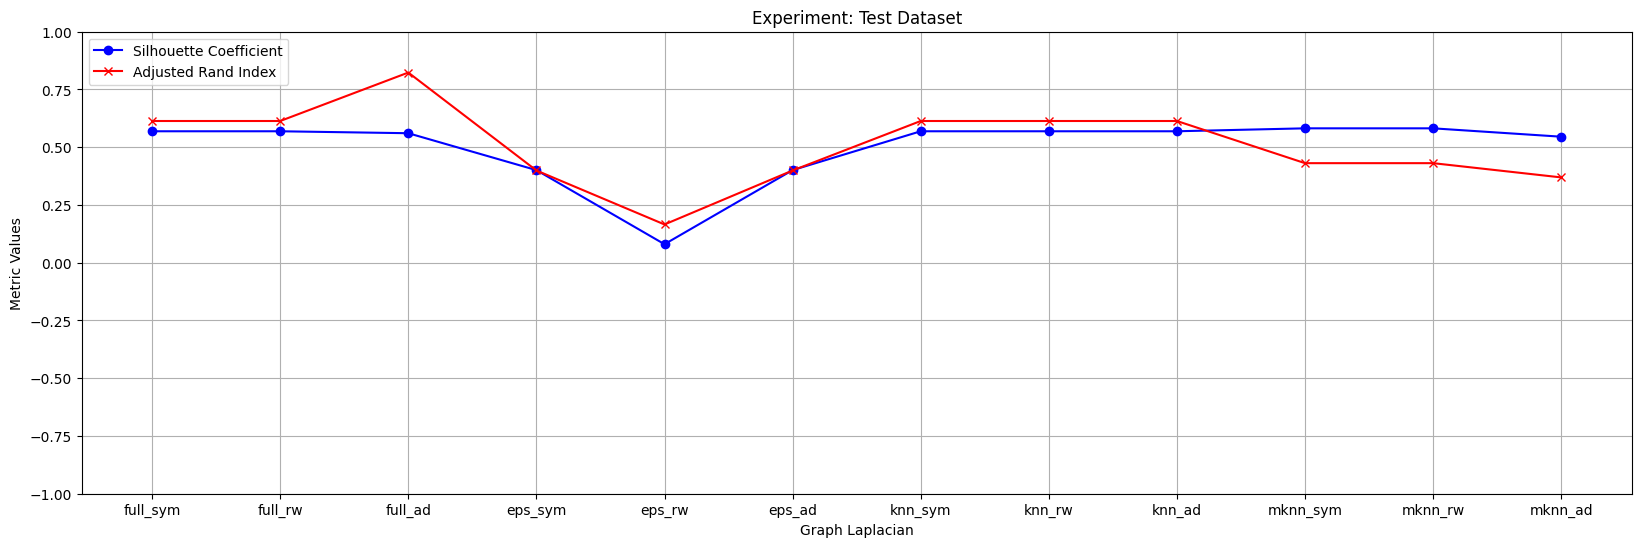

In [17]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Define an offset to avoid overlap
offset = 0.05

# Plot silhouette coefficient with an offset
ax.plot(experiment_iris['graph_laplacian'], 
        experiment_iris['silhouette'] + offset, 
        marker='o', color='b', label='Silhouette Coefficient', markersize=6)

# Plot Adjusted Rand Index with an offset
ax.plot(experiment_iris['graph_laplacian'], 
        experiment_iris['adjusted_rand'], 
        marker='x', color='r', label='Adjusted Rand Index', markersize=6)

# Set labels
ax.set_xlabel('Graph Laplacian')
ax.set_ylabel('Metric Values')

# Adjust y-axis limits dynamically
ax.set_ylim(-1, 1)  # Set limits to fit the offsets

# Add a title
plt.title('Experiment: Test Dataset')

# Add a legend
ax.legend(loc='upper left')

# Show grid for better readability
plt.grid()

# Show the plot
plt.show()

In [18]:
# Visualization function
def visualize_clusters(data, cluster_labels, title):
    """
    Visualize clustered data using PCA.
    
    Parameters:
    data (DataFrame): The original data used for clustering.
    cluster_labels (ndarray): Cluster labels from the clustering algorithm.
    title (str): Title of the plot.
    """
    # Reduce data to 2D using PCA if necessary
    if data.shape[1] > 2:
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(data)
    else:
        reduced_data = data.values  # If data is already 2D
    
    # Create scatter plot with clusters
    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    
    # Adding title and labels
    plt.title(f'Cluster Visualization - {title}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

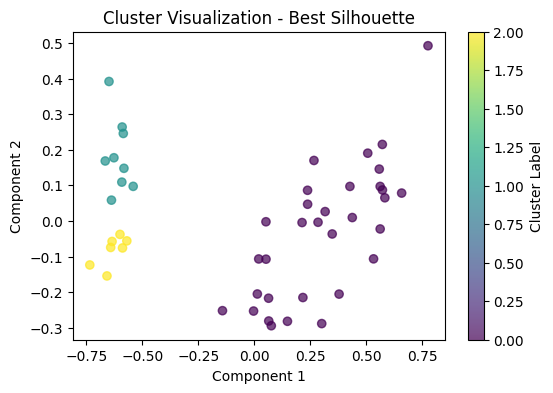

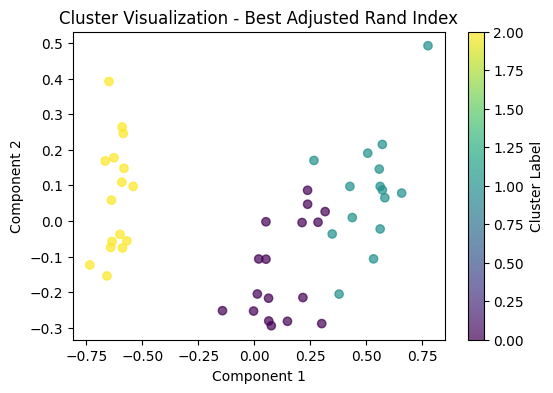

In [19]:
# Extracting cluster labels for best silhouette, adjusted rand, and adjusted mutual info indices
best_silhouette_clusters = cluster_labels[best_silhouette_index]
best_adjusted_rand_clusters = cluster_labels[best_adjusted_rand_index]

# Visualizing the best clusters for each metric
visualize_clusters(data_df, best_silhouette_clusters, 'Best Silhouette')
visualize_clusters(data_df, best_adjusted_rand_clusters, 'Best Adjusted Rand Index')